# **NOTEBOOK 3: MODELS**

In this notebook, we are going to test different algorithms to predict how many parcels will be registered in the system the next day.

---

Once the input data has been processed and analyzed, the next step is modeling, i.e. building models to solve our problem: predicting the number of packages registered in the system of a parcel delivery company on the following day.

The prediction of time series is a common problem, and can be found in various fields such as predicting energy consumption, sales of a given company, traffic congestion, attendance at an establishment or calls to an emergency service, for example.

There is a large number of models capable of solving this problem of predictive analytics, so in this work 6 models of different types will be tested in order to compare them with each other and as a way of learning for the student by the diversity of them. The results will be compared and the best of them will be established, which will be the one chosen for the final interface.

The models to be tested are the following:
* SARIMAX
* PROPHET
* KNN
* RANDOM FOREST REGRESSOR
* XGBOOST
* LSTM

# Import libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#from fbprophet import Prophet

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from keras.layers import Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense

import joblib

We start where we left off in the previous notebook, we have to remember that we have a time series with the number of packets registered in the system per day and we have identified the types of calendar days and major lags that affect the series.

In [74]:
# url initial data
url = '../files/data/daytypelags2017_parcels.csv'
# read the previous CSV file with the data (parcels, calendar data and lags)
df_complete_models = pd.read_csv(url, sep=",", 
                                 index_col='date')
df_complete_models.index = pd.to_datetime(df_complete_models.index)
df_complete_models.head()

,n_parcels,weekday,monthday,month,year,date_c,yearday,fest,eve,postFest,...,gap-1,gap-2,gap-3,gap-4,gap-6,gap-7,gap-14,gap-21,gap-28,gap-365
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,92.0,1,1,1,2017,2017-01-01,1,False,True,False,...,903.0,141984.0,155798.0,156875.0,42071.0,6.0,29760.0,27698.0,31996.0,6464.0
2017-01-02,145745.0,2,2,1,2017,2017-01-02,2,True,False,False,...,92.0,903.0,141984.0,155798.0,180965.0,42071.0,218805.0,194117.0,185622.0,26144.0
2017-01-03,172005.0,3,3,1,2017,2017-01-03,3,False,False,True,...,145745.0,92.0,903.0,141984.0,156875.0,180965.0,188453.0,177606.0,4065.0,113361.0
2017-01-04,146216.0,4,4,1,2017,2017-01-04,4,False,False,False,...,172005.0,145745.0,92.0,903.0,155798.0,156875.0,181162.0,174722.0,190351.0,89541.0
2017-01-05,117517.0,5,5,1,2017,2017-01-05,5,False,True,False,...,146216.0,172005.0,145745.0,92.0,141984.0,155798.0,172260.0,167108.0,5493.0,561.0


First of all, let's prepare the dataset that we will later divide into train and test. For them we are going to choose the columns with the following variables:

Calendar variables: 
* Fest: 1 if the day is a public holiday, 0 if not.
* Saturday: 1 if the day is Saturday, 0 otherwise.
* Sunday: 1 if the day is Sunday, 0 otherwise.
* blackFriday: 1 if the day is Black Friday, 0 if not.
* blackFridayWeek: 1 if the day belongs to Black Friday week, 0 otherwise.
* COVID: 1 if the day belongs to the period defined as COVID, 0 otherwise.
* Christmas: 1 if the day belongs to the Christmas period, 0 otherwise.

Lag variables: number of packets recorded for lag1, lag2, lag3, lag4, lag6, lag7, lag14, lag21, lag28 and lag365.




In [75]:
# get column names
df_complete_models.columns

Index(['n_parcels', 'weekday', 'monthday', 'month', 'year', 'date_c',
       'yearday', 'fest', 'eve', 'postFest', 'saturday', 'sunday', 'weekend',
       'workable', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas',
       'typeDay', 'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7',
       'gap-14', 'gap-21', 'gap-28', 'gap-365'],
      dtype='object')

In [76]:
# select endogenous and exogenous variables
df_selected_models = df_complete_models.copy()
df_selected_models = df_selected_models[['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                                         'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365', 
                                         'n_parcels']]


**Train and test**

Prior to testing the models, it is necessary to divide the data into train and test so that they will first be trained with the train data and then evaluated with the test data, on which the associated error will be calculated to quantify their performance.

Previously it was decided to use the time series starting from the years 2016-2017. Therefore, and as we have the lag365, the train data are going to have their starting point in 2017 in a complete way (with the lag365 with 2016 data). 

In some models, we will need to normalize the data, so we will now normalize the data and then generate the normalized (using MinMaxScaler from sklearn) and unnormalized train and test.

In [77]:
# generate scaler (0, 1)
scaler_1 = MinMaxScaler(feature_range=(0, 1))
scaled_1 = scaler_1.fit_transform(df_selected_models)
df_scaled_selected_models = pd.DataFrame(scaled_1)

In [78]:
# prepare X and y dataframes with the variables and integer index
X = df_selected_models[['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                        'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365']]
y = df_selected_models[['n_parcels']]

Xforindex = X.copy()

X['fest'] = X['fest'].astype(float)
X['blackFriday'] = X['fest'].astype(float)
X['blackFridayWeek'] = X['fest'].astype(float)
X['COVID'] = X['fest'].astype(float)
X['Christmas'] = X['fest'].astype(float)

X_scaled = df_scaled_selected_models.iloc[:, :-1]
X_scaled.columns = ['fest', 'saturday', 'sunday', 'blackFriday', 'blackFridayWeek', 'COVID', 'Christmas', 
                    'gap-1', 'gap-2', 'gap-3', 'gap-4', 'gap-6', 'gap-7', 'gap-14', 'gap-21', 'gap-28', 'gap-365']
y_scaled = df_scaled_selected_models.iloc[:, -1]
y_scaled.columns = ['n_parcels']
X.reset_index(inplace=True)
X.drop('date', axis=1, inplace=True)
y.reset_index(inplace=True)
y.drop('date', axis=1, inplace=True)

In addition, it is established, in an orderly manner, that the train data set consists of 80% of the sample while the test data set contains the remaining 20% of data. 

In [79]:
# generate train and test (scaled and unscaled)
train_size = int(round(len(X)*0.8, 0))
test_size = int(len(X)) - train_size

train_2017_X,  train_2017_y = X.iloc[:len(X) - test_size, :], y.iloc[-train_size-test_size:-test_size]
test_2017_X, test_2017_y = X.iloc[- test_size:, :], y.iloc[- test_size:]

scaled_train_2017_X, scaled_train_2017_y = X_scaled.iloc[:len(X) - test_size, :], y_scaled.iloc[-train_size-test_size:-test_size]
scaled_test_2017_X, scaled_test_2017_y = X_scaled.iloc[- test_size:, :], y_scaled.iloc[- test_size:]

Let's take a look at the appearance of our train and test.

Text(0.5, 1.0, 'Train/test')

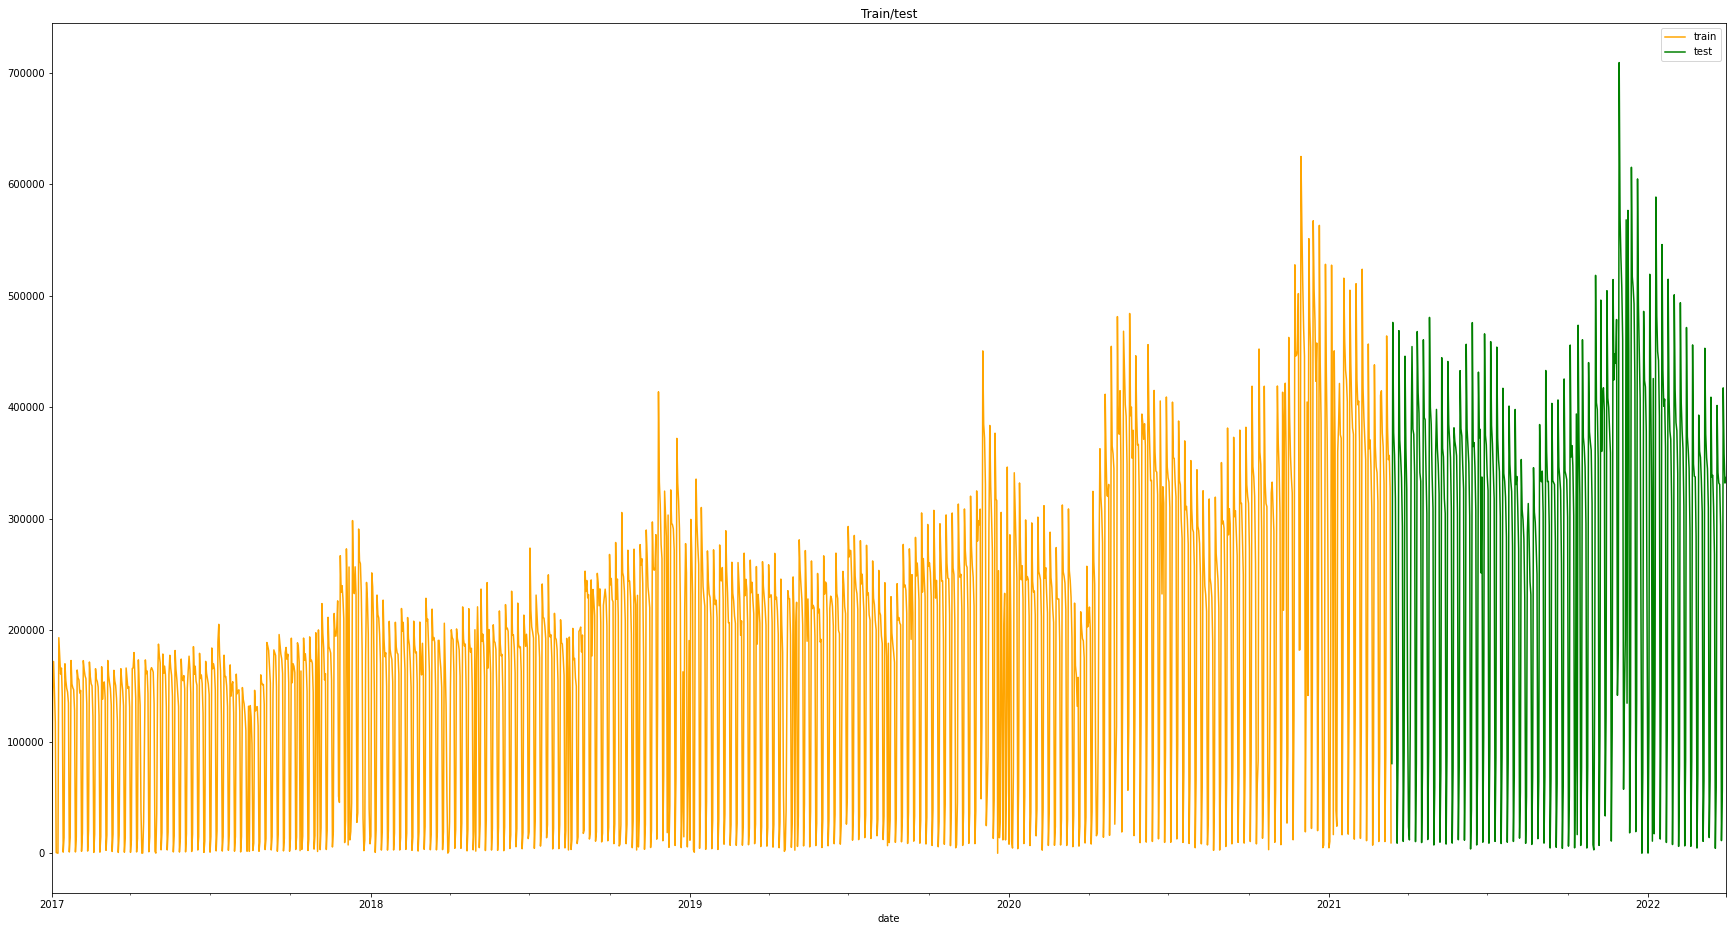

In [80]:
# show train and test
tr_2017_plot = train_2017_y.copy()
tr_2017_plot.index = Xforindex.iloc[:train_size].index
te_2017_plot = test_2017_y.copy()
te_2017_plot.index = Xforindex.iloc[train_size:].index
plot_train_test = pd.DataFrame()
plot_train_test = pd.concat([tr_2017_plot, te_2017_plot])
plot_train_test['train'] = tr_2017_plot
plot_train_test['test'] = te_2017_plot
plot_train_test['train'].plot(figsize=(30, 16), legend=True, color='orange')
plot_train_test['test'].plot(figsize=(30, 16), legend=True, color='green').set_title('Train/test')

Thus, both datasets are defined between the following dates:

* Train: from 2017-01-01 to 2021-03-13.
* Test: from 2021-03-14 to 2022-03-31.

# Models

As the different prediction models are implemented, their errors will be compiled for later comparison. There are a number of typical errors used for model evaluation (MSE, RMSE, R^2, MAE, MAPE, etc). However, the errors chosen for this problem are the following:
* RMSE (root mean square error): consists in comparing the actual values with the predicted values through the Euclidean distance of the values.
* MAE (mean absolute error): it is calculated as the average of absolute differences between the actual values and the predicted values so that all differences are weighted in the same way.

These two errors are chosen because, on the one hand, the RMSE gives importance to high and low values, which makes sense in the time series in question because there are continuously very high values (Black Friday and Christmas period) and very low values, such as weekends, so it is interesting to adjust to those values. And, on the other hand, the MAE provides a more general view of the error over the whole series.

The models to implement are the following:

*   SARIMAX
*   PROPHET
*   KNN
*   RANDOM FOREST
*   XGBOOST
*   LSTM

In [81]:
# declare errors dataframe in order to record models errors (RMSE and MAE)
errors = pd.DataFrame()
errors = pd.DataFrame(columns=['RMSE','MAE'])
errores = {}

**SARIMAX**

The first model we are going to implement is SARIMAX. SARIMAX (Autoregressive Moving Average with Exogenous Factors) model is a linear regression model that uses a seasonal ARIMA type model of residuals allowing for exogenous variables. Typically, ARMA-based models are usually a good model to start with, being able to achieve decent results and serving as a benchmark model for time series problems.

In this case, we will first use the auto_arima function of the pmdarima library to compute the parameters (p, d, q). These parameters indicate the order of the various components of the model. First, the p (AR part) represents the autoregression order, i.e., up to what lag a variable depends on the values of itself in the past. Second, the q (part MA) indicates up to which lag a variable depends on the errors of its previous observations, i.e., the moving average order. Finally, the term d (part I) corresponds to the order of the integration part.

In [82]:
# run auto arima
model_auto_arima = auto_arima(scaled_train_2017_y, exogenous=scaled_train_2017_X, 
                     start_p=1, start_q=1, 
                     max_p=8, max_q=8,  
                     d=1, max_d=8, 
                     trace=True, 
                     error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4817.199, Time=4.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4344.217, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4540.360, Time=3.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4789.060, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4346.215, Time=2.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4821.666, Time=5.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4621.956, Time=4.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4784.598, Time=5.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4797.834, Time=5.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4815.961, Time=4.93 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4701.685, Time=5.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4809.093, Time=5.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4824.480, Time=4.67 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-4822.099, Time=4.46 sec
 ARIMA(2,1,0)(0,0,0

Now we pass the best parameters calculated by auto arima to the SARIMAX model (statsmodels). Then, the model is fitted and test predictions are calculated and plotted.

In [83]:
# SARIMAX model
model_sarimax = SARIMAX(scaled_train_2017_y, exog=scaled_train_2017_X, order=model_auto_arima.get_params()['order'], enforce_invertibility=False, enforce_stationarity=False)
# fit
sarimax_fitted = model_sarimax.fit()
# predict test
sarimax_scaled_predictions_test = sarimax_fitted.predict(start=train_size, end=train_size+test_size-1, exog=scaled_test_2017_X)

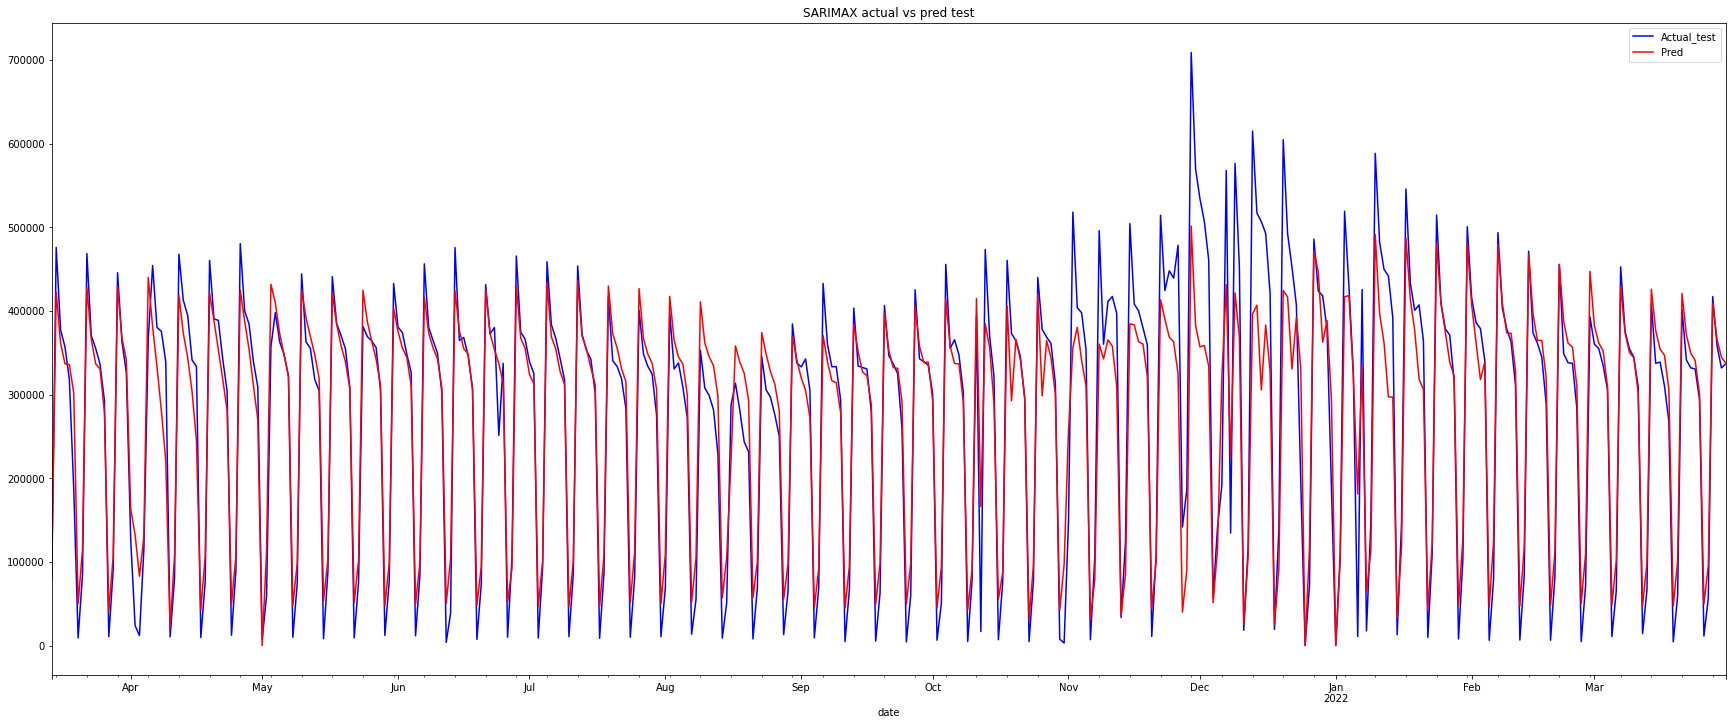

In [84]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
prepare_unscaled = scaled_test_2017_X.copy()
prepare_unscaled['scaled_pred'] = sarimax_scaled_predictions_test.values
unscaled_predictions = scaler_1.inverse_transform(prepare_unscaled)
predictions = pd.DataFrame(unscaled_predictions[:, -1:])
predictions.index = test_2017_X.index
predictions['Actual_test'] = act_test['n_parcels']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions.index = Xforindex.iloc[train_size:].index
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('SARIMAX actual vs pred test')
predictions_SARIMAX = predictions.copy()

There is some difficulty in fully approaching the weekend lows, and it also has problems in periods of higher volume and volatility at the end of the year because it does not increase its forecasts at all.

In [85]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_SARIMAX['Pred'], predictions_SARIMAX['Actual_test']), meanabs(predictions_SARIMAX['Pred'], predictions_SARIMAX['Actual_test'])]

**PROPHET**

The second model we are going to implement is Prophet. Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data, which is interesting because in the previous decomposition only one seasonality could be identified. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

First, we will generate the calendars and datasets with the format required by Prophet and then we will test it to see and save its results.

In [86]:
# generate holidays

h_nationals = pd.DataFrame({
    'holiday': 'national',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['fest']].index)
})

h_saturdays = pd.DataFrame({
    'holiday': 'saturdays',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['saturday']].index)
})

h_sundays = pd.DataFrame({
    'holiday': 'sundays',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['sunday']].index)
})

h_black_friday = pd.DataFrame({
    'holiday': 'black_friday',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['blackFriday']].index)
})

h_black_friday_week = pd.DataFrame({
    'holiday': 'black_friday_week',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['blackFridayWeek']].index)
})

h_covid = pd.DataFrame({
    'holiday': 'covid',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['COVID']].index)
})

h_christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(df_selected_models[df_selected_models['Christmas']].index)
})

df_holidays = pd.concat((h_nationals, h_saturdays, h_sundays, h_black_friday, h_black_friday_week, h_covid, h_christmas))

In this case we can pass the data without scaling because prophet takes care of it.

In [87]:
# prepare data
train_prophet_ex = pd.DataFrame()
train_prophet_ex = X[['gap-1',	'gap-2',	'gap-3',	'gap-4', 'gap-6', 'gap-7', 'gap-14',	'gap-21',	'gap-28',	'gap-365']][:train_size].copy()
train_prophet_ex['ds'] = Xforindex.iloc[:train_size].index
train_prophet_ex['y'] = train_2017_y.values

Initially, the notebooks were developed in Google Colab, where prophet could be imported without problems. However, in this development environment it has been impossible to properly install the module. Therefore, the code is shown commented, the images with the output are added and the error is added to the error dataframe. In addition, these can be found in the memory doc.

In [88]:
# Prophet model
#model_prophet = Prophet(holidays=df_holidays)
# add regressors with lags
#model_prophet.add_regressor('gap-1')
#model_prophet.add_regressor('gap-2')
#model_prophet.add_regressor('gap-2')
#model_prophet.add_regressor('gap-3')
#model_prophet.add_regressor('gap-4')
#model_prophet.add_regressor('gap-6')
#model_prophet.add_regressor('gap-7')
#model_prophet.add_regressor('gap-14')
#model_prophet.add_regressor('gap-21')
#model_prophet.add_regressor('gap-28')
#model_prophet.add_regressor('gap-365')
# Fit
#model_prophet.fit(train_prophet_ex)
# Forecast
#future = model_prophet.make_future_dataframe(periods=test_size)
#future = pd.concat([future, X[['gap-1',	'gap-2',	'gap-3',	'gap-4', 'gap-6', 'gap-7', 'gap-14',	'gap-21',	'gap-28', 'gap-365']]], axis=1)
#forecast_prophet = model_prophet.predict(future)

In addition, Prophet provides tools that make it easy to visualize the different components.

In [89]:
# plot forecast components
#fig = model_prophet.plot_components(forecast_prophet)

<img src="./images_prophet/p1.png">
<img src="./images_prophet/p2.png">

We see how the positive trend at all times undergoes an even greater increase from 2020 onwards as a consequence of the effect of COVID on people's lives and the transformation it has undergone towards a world where online commerce has been highly affected in a positive way.
In addition, both weekly and annual seasonality is observed, which has its higher peaks at the end of the year and lower peaks in the summer vacation period.

In [90]:
# prepare and plot test data and predictions
#act_test = pd.DataFrame(y.iloc[train_size:])
#predictions = pd.DataFrame()
#predictions['Pred'] = forecast_prophet['yhat'][train_size:]
#predictions['Actual_test'] = act_test['n_parcels']
#predictions.reset_index(drop=True, inplace=True)
#predictions.index = Xforindex.iloc[train_size:].index
#predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
#predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
#predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('Prophet actual vs pred test')
#predictions_Prophet = predictions.copy()

<img src="./images_prophet/p3.png">

In this case, it fits even less to the lower values corresponding to weekends, probably due to the resulting trend after 2020 indicating a very steep increase. However, it seems to fit better to the higher values.

In [91]:
# record errors
errors.loc[len(errors.index)] = [55870.203534,	42357.515211]

**KNN**

The next model is k-nearest neighbors (KNN). It is an algorithm is a simple, easy-to-implement supervised machine learning algorithm that can be used to solve both classification and regression problems. It is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.

To do this, we will first make use of grid search to obtain the best parameters and, as before, we will then train the model using the KNeighborsRegressor function from sklearn and test it with the test data to calculate its associated errors and plot the results.

In this case we have to use the scaled data, since this algorithm needs it beacuse it uses euclidean distances.

In [92]:
# run KNN in GridSearchCV
gsKNNreg=GridSearchCV(KNeighborsRegressor(),
                    param_grid={"n_neighbors":np.arange(1,100)},
                    scoring='neg_mean_squared_error')

gsKNNreg.fit(scaled_train_2017_X, scaled_train_2017_y)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='neg_mean_squared_error')

In [93]:
# run knn regressor
estimatorKNN = KNeighborsRegressor().set_params(**gsKNNreg.best_params_)
estimatorKNN.fit(scaled_train_2017_X, scaled_train_2017_y)
y_predictKNN = estimatorKNN.predict(scaled_test_2017_X)

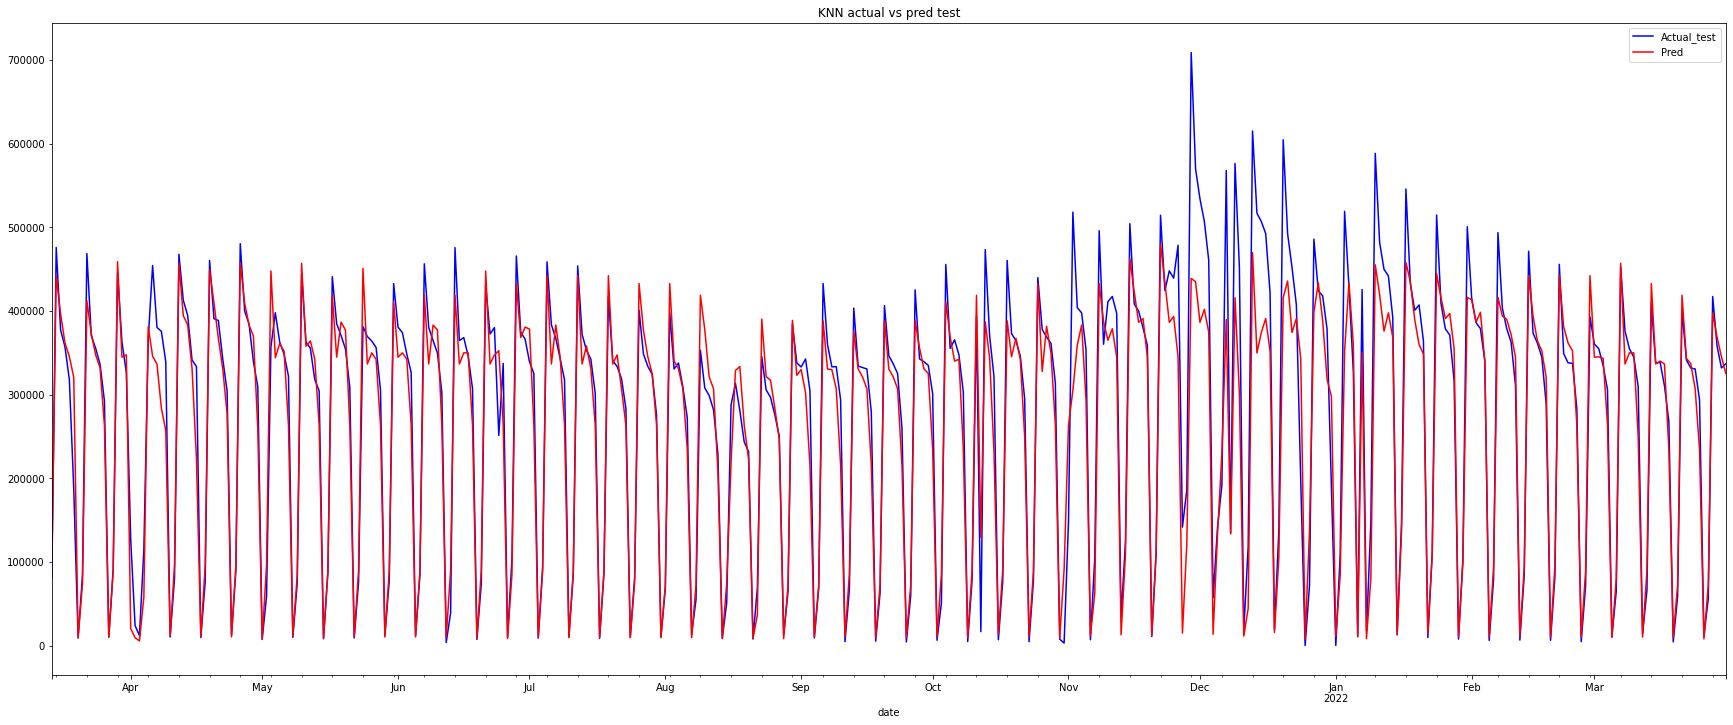

In [94]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
prepare_unscaled = scaled_test_2017_X.copy()
prepare_unscaled['scaled_pred'] = y_predictKNN
unscaled_predictions = scaler_1.inverse_transform(prepare_unscaled)
predictions = pd.DataFrame(unscaled_predictions[:, -1:])
predictions.index = test_2017_X.index
predictions['Actual_test'] = act_test['n_parcels']
predictions.rename(columns={0:'Pred'}, inplace=True)
predictions.index = Xforindex.iloc[train_size:].index
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('KNN actual vs pred test')
predictions_KNN = predictions.copy()


In this case, it can be observed that it performs very well with the low values of weekends (similar to those of Saturdays and Sundays), showing, on the other hand, a worse performance in periods of high volume and volatility, since it does not adapt to year-end peaks either.

In [95]:
errors.loc[len(errors.index)] = [rmse(predictions_KNN['Pred'], predictions_KNN['Actual_test']), meanabs(predictions_KNN['Pred'], predictions_KNN['Actual_test'])]

**RANDOM FOREST**

The next and fourth model we are going to implement is Random Forest for regression. A Random Forest is an ensemble of decision trees combined with bagging. When using bagging, what is actually happening is that different trees see different portions of the data. No single tree sees all of the training data. This results in each tree being trained with different data samples for the same problem. In this way, by combining their results, some errors are compensated by others and we have a prediction that generalizes better.

To do this, we will first make use of grid search to obtain the best parameters and, as before, we will then train the model and test it with the test data to calculate its associated errors and plot the results.

In this case it has been decided to use GridSearchCV for the parameters max_depth, n_estimators, max_features and bootstrap with MSE as a function to be minimized as a test to be executed in an affordable time.

Also, we can use the data without scaling, since this type of algorithm does not need it.

In [96]:
# run Random Forest Regressor in GridSearchCV
gsRFreg = GridSearchCV(RandomForestRegressor(),
                   param_grid={"max_depth":  [25, 50, 75, 100], 
                              "n_estimators": [50, 75, 100, 125, 150],
                                "max_features": ["auto", "log2"],
                                "bootstrap": [True, False]},
                   scoring="neg_mean_squared_error",
                   verbose=2)

gsRFreg.fit(train_2017_X, train_2017_y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.4s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5s
[CV] END bootstrap=True, max_depth=25, max_features=auto, n_estimators=75; total time=   0.5

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [25, 50, 75, 100],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [50, 75, 100, 125, 150]},
             scoring='neg_mean_squared_error', verbose=2)

In [97]:
# run Random Forest Regressor
estimatorRFR = RandomForestRegressor(n_jobs=-1).set_params(**gsRFreg.best_params_)
estimatorRFR.fit(train_2017_X, train_2017_y)
y_predictRFR = estimatorRFR.predict(test_2017_X)

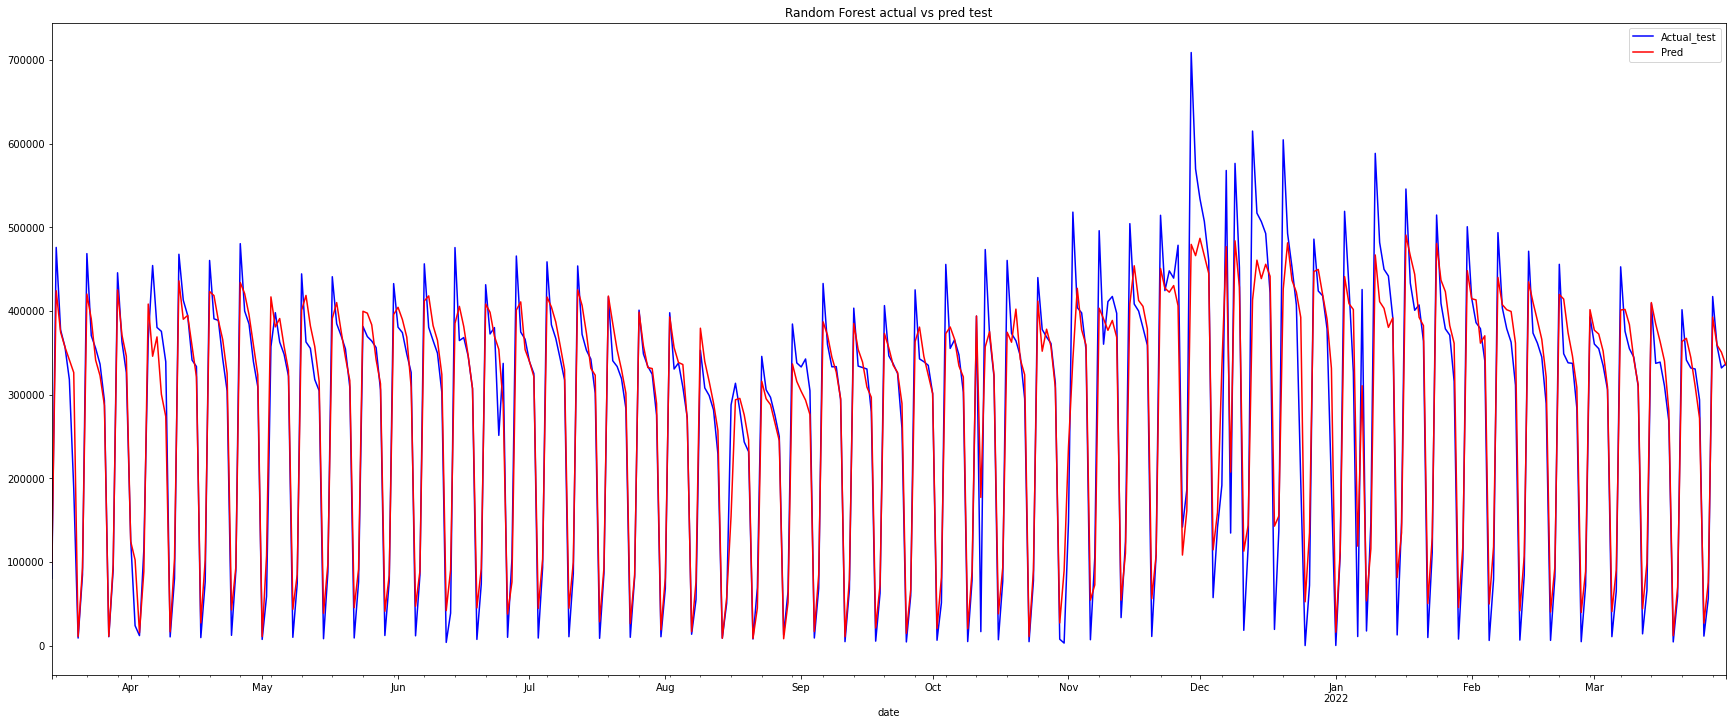

In [98]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = y_predictRFR
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('Random Forest actual vs pred test')
predictions_RF = predictions.copy()

In this case, it behaves close to low values on some occasions, but not in all cases, while for high volumes and higher volatility it offers a better performance than SARIMAX or KNN.  

<BarContainer object of 17 artists>

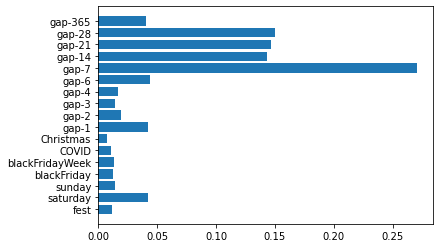

In [99]:
# feature importances
plt.barh(train_2017_X.columns, estimatorRFR.feature_importances_)

It is observed that the variables with the greatest weight are those of lag7 and multiples, in addition to Saturdays (the day of the week with the lowest volume of records).

In [100]:
# Record errors
errors.loc[len(errors.index)] = [rmse(predictions_RF['Pred'], predictions_RF['Actual_test']), meanabs(predictions_RF['Pred'], predictions_RF['Actual_test'])]

**XGBoost**

The fifth model we are going to implement is XGBoost for regression. XGBoost is an efficient implementation of gradient boosting that can be used for regression predictive modeling.

It is a parallelizable algorithm, which allows optimal use of the available processing power by using multiple cores at the same time, thus achieving a very high training speed. This makes it ideal for large data sets.

To do this, we will first make use of grid search to obtain the best parameters (we are looking for the number of estimators) and, as before, we will then train the model and test it with the test data to calculate its associated errors and plot the results. This is done with its own module.

In this case we can use the data without scaling, since this type of algorithm does not need it.

In [101]:
# run XGBoost in GridSearchCV
gscXGB = GridSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={'n_estimators': [750, 1000, 1250, 1500],
                        },
                   scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

gscXGB.fit(train_2017_X, train_2017_y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[11:47:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'n_estimators': [750, 1000, 1250, 1500]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [102]:
# run XGBoost Regressor
estimatorXGB = xgb.XGBRegressor(n_estimators=gscXGB.best_params_['n_estimators'])
estimatorXGB.fit(train_2017_X, train_2017_y, verbose=False)
y_predictXGB = estimatorXGB.predict(test_2017_X)

[11:47:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


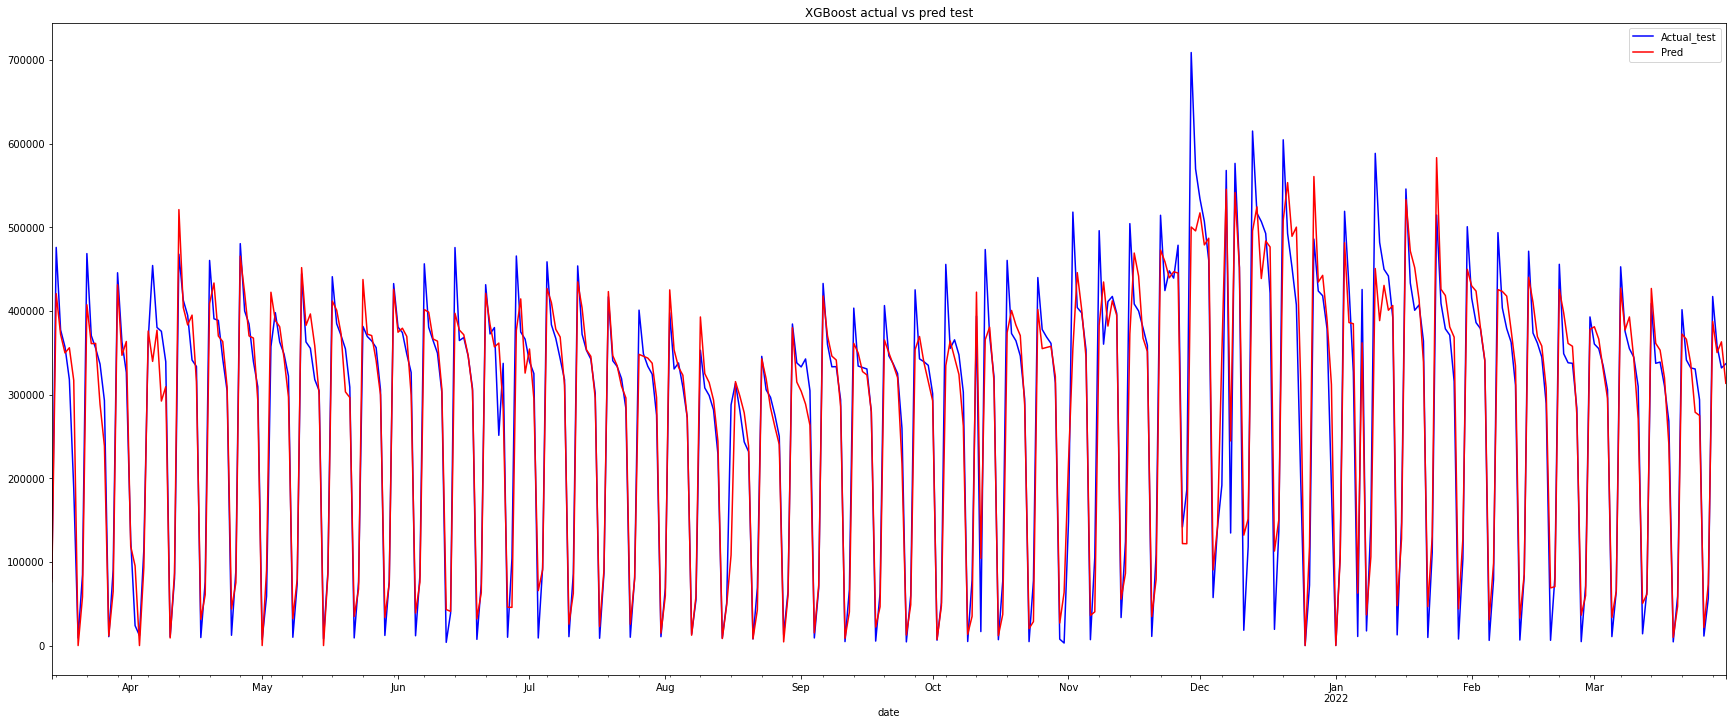

In [103]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = y_predictXGB
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('XGBoost actual vs pred test')
predictions_XGB = predictions.copy()

This algorithm performs well both at low volumes (although it does not quite fit, it is quite decent), and it also approaches high volumes, showing a priori the best results so far.

Regarding the importance of the different variables introduced in the model, we obtain the following:

<BarContainer object of 17 artists>

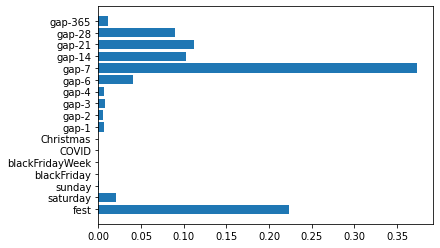

In [104]:
# feature importances
plt.barh(train_2017_X.columns, estimatorXGB.feature_importances_)

In this case, the importance of the variables can be seen more clearly, where lag7 is of great importance followed by its multiples and, in second place, national holidays.

In [105]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_XGB['Pred'], predictions_XGB['Actual_test']), meanabs(predictions_XGB['Pred'], predictions_XGB['Actual_test'])]

**LSTM**

The sixth and last algorithm we will implement is LSTM. LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.

In this case it is necessary for the data to be scaled, so the data prepared for this purpose is used. In addition, it needs transformations of the input data and inverse transformations for the results after adapting the data to the shape required by the networks. 

To implement this model, keras and its components are used. Keras is a very important module that provides modular blocks on which complex Deep Learning models can be developed. As for the implemented network, it consists of the LSTM itself, dropout and the output dense layer, all of them with a typical configuration of their parameters.

In [106]:
# prepare data
scaled_train_2017_X_lstm_np = scaled_train_2017_X.to_numpy()
scaled_train_2017_y_lstm_np = scaled_train_2017_y.to_numpy()
scaled_test_2017_X_lstm_np = scaled_test_2017_X.to_numpy()
scaled_test_2017_y_lstm_np = scaled_test_2017_y.to_numpy()

scaled_train_2017_X_lstm = scaled_train_2017_X_lstm_np.reshape((scaled_train_2017_X_lstm_np.shape[0], 1, scaled_train_2017_X_lstm_np.shape[1]))
scaled_test_2017_X_lstm = scaled_test_2017_X_lstm_np.reshape((scaled_test_2017_X_lstm_np.shape[0], 1, scaled_test_2017_X_lstm_np.shape[1]))

In [107]:
# LSTM
# set LSTM parameters
dropoutIndex = 0.0
neuronsLSTMLayer = 50
neuronsOutputLayer = 1
lossFunction = 'mean_squared_error'
Optimizer = 'adam'
Epochs = 80
batchSize = 64

# model
model = Sequential()
model.add(LSTM(neuronsLSTMLayer, input_shape = (scaled_train_2017_X_lstm.shape[1], scaled_train_2017_X_lstm.shape[2])))
model.add(Dropout(dropoutIndex))
model.add(Dense(neuronsOutputLayer))
model.compile(loss = lossFunction, optimizer = Optimizer)

# fit
history = model.fit(scaled_train_2017_X_lstm, scaled_train_2017_y_lstm_np, epochs = Epochs, batch_size = batchSize, validation_data = (scaled_test_2017_X_lstm, scaled_test_2017_y_lstm_np), verbose = 2, shuffle=False)

Epoch 1/80
24/24 - 2s - loss: 0.0286 - val_loss: 0.0265 - 2s/epoch - 87ms/step
Epoch 2/80
24/24 - 0s - loss: 0.0086 - val_loss: 0.0126 - 87ms/epoch - 4ms/step
Epoch 3/80
24/24 - 0s - loss: 0.0047 - val_loss: 0.0080 - 96ms/epoch - 4ms/step
Epoch 4/80
24/24 - 0s - loss: 0.0036 - val_loss: 0.0064 - 74ms/epoch - 3ms/step
Epoch 5/80
24/24 - 0s - loss: 0.0032 - val_loss: 0.0058 - 77ms/epoch - 3ms/step
Epoch 6/80
24/24 - 0s - loss: 0.0031 - val_loss: 0.0054 - 87ms/epoch - 4ms/step
Epoch 7/80
24/24 - 0s - loss: 0.0029 - val_loss: 0.0052 - 88ms/epoch - 4ms/step
Epoch 8/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0050 - 93ms/epoch - 4ms/step
Epoch 9/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0049 - 85ms/epoch - 4ms/step
Epoch 10/80
24/24 - 0s - loss: 0.0028 - val_loss: 0.0049 - 100ms/epoch - 4ms/step
Epoch 11/80
24/24 - 0s - loss: 0.0027 - val_loss: 0.0048 - 80ms/epoch - 3ms/step
Epoch 12/80
24/24 - 0s - loss: 0.0027 - val_loss: 0.0047 - 78ms/epoch - 3ms/step
Epoch 13/80
24/24 - 0s - loss: 0.0027

In [108]:
# test prediction
yhat = model.predict(scaled_test_2017_X_lstm)
a = scaled_test_2017_X_lstm.reshape((scaled_test_2017_X_lstm.shape[0], scaled_test_2017_X_lstm.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((a, yhat), axis=1)
inv_yhat = scaler_1.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

12/12 [==============================] - 0s 1ms/step


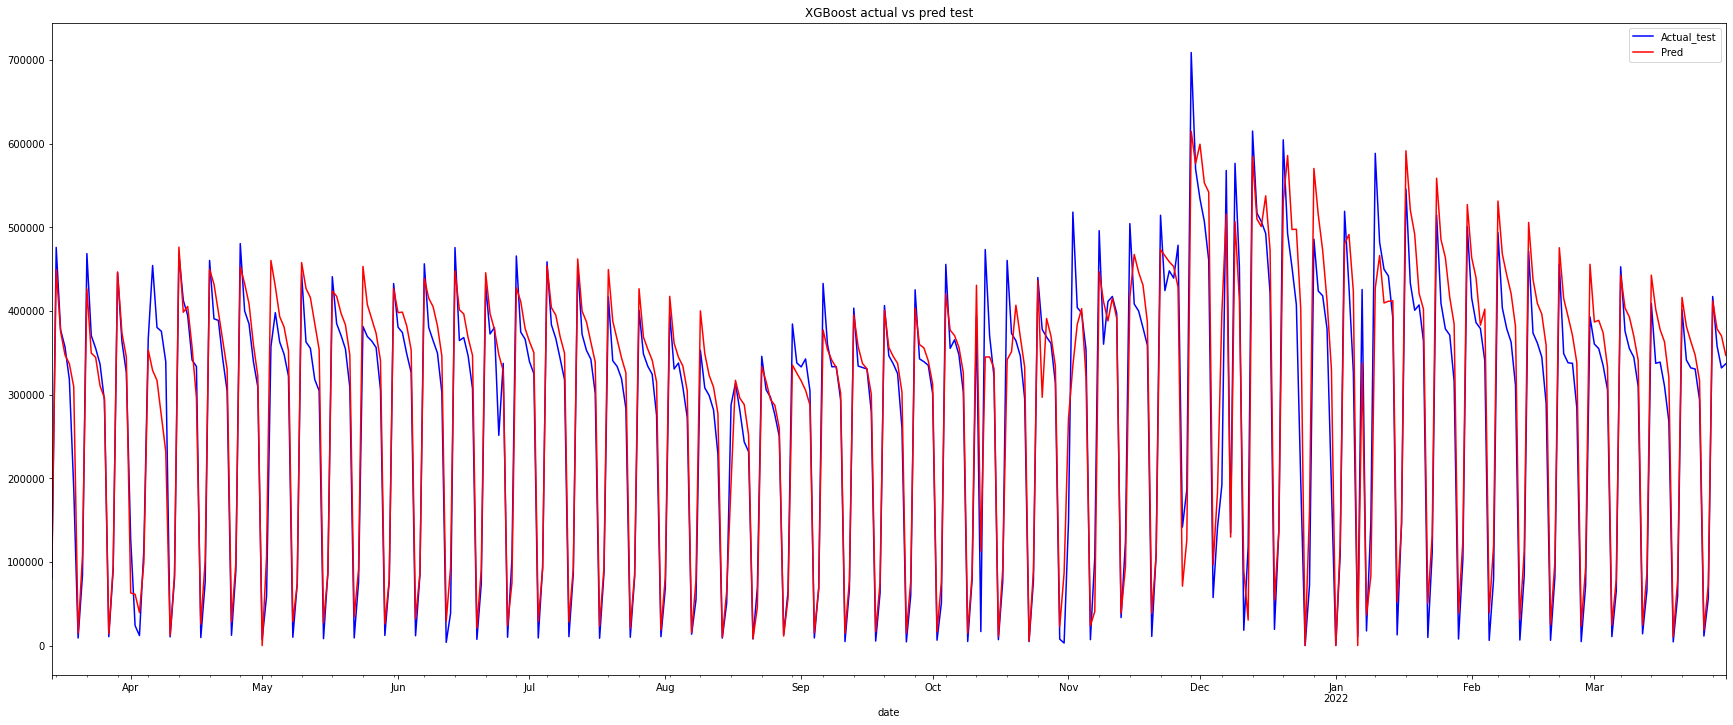

In [109]:
# prepare and plot test data and predictions
act_test = pd.DataFrame(y.iloc[train_size:])
act_test.index = Xforindex.iloc[train_size:].index
predictions = pd.DataFrame()
predictions['Pred'] = inv_yhat
predictions.index = Xforindex.iloc[train_size:].index
predictions['Actual_test'] = act_test['n_parcels']
predictions['Pred'] = predictions.apply(lambda x: 0 if x['Pred'] < 0 else x['Pred'], axis=1)
predictions['Actual_test'].plot(figsize=(30, 12), legend=True, color='blue')
predictions['Pred'].plot(figsize=(30, 12), legend=True, color='red').set_title('XGBoost actual vs pred test')
predictions_LSTM = predictions.copy()

It can be observed that both the high and low values approximate each other acceptably. However, it shows differences in the values of the mid-week days as they progress.

In [110]:
# record errors
errors.loc[len(errors.index)] = [rmse(predictions_LSTM['Pred'], predictions_LSTM['Actual_test']), meanabs(predictions_LSTM['Pred'], predictions_LSTM['Actual_test'])]

# Evaluation

In this section we are going to analyze the errors of the models in order to choose the best one for our future predictions.

We have chosen the errors RMSE and MAE. This is because the rmse gives importance to high and low values which in our case are shown on weekends or Black Friday and the MAE provides a more general view of the error.

In [117]:
# errors recorded
errors['models'] = ['SARIMAX', 'Prophet', 'KNN', 'Random Forest', 'XGBoost', 'LSTM']
errors

,RMSE,MAE,models
0,53656.031948,37667.855030,SARIMAX
1,55870.203534,42357.515211,Prophet
2,49831.885970,31890.101175,KNN
3,44943.222224,30531.417441,Random Forest
4,41747.458484,28268.717799,XGBoost
5,45027.742670,32911.297351,LSTM


Text(0.5, 1.0, 'RMSE comparison')

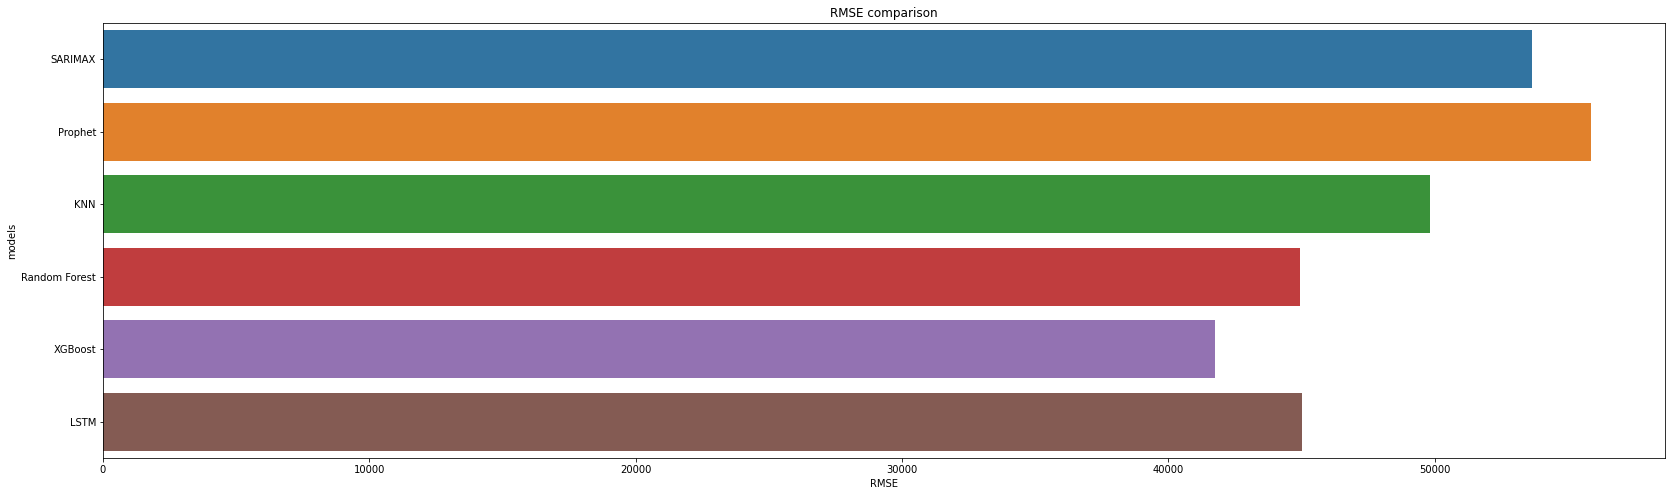

In [118]:
# plot rmse
plt.figure(figsize=(28, 8))
sns.barplot(data=errors, x='RMSE', y='models').set_title('RMSE comparison')

Text(0.5, 1.0, 'MAE comparison')

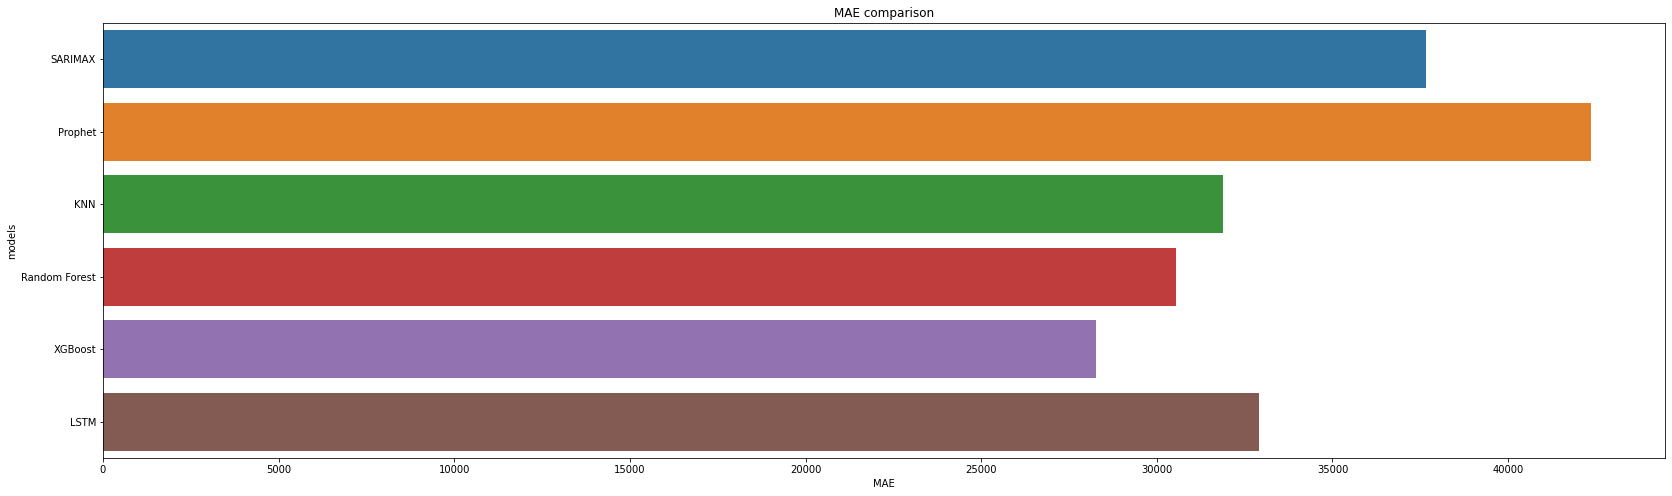

In [119]:
# plot mae
plt.figure(figsize=(28, 8))
sns.barplot(data=errors, x='MAE', y='models').set_title('MAE comparison')

It can be seen that in the case of both RMSE and MAE both XGBoost and then Random Forest differ from the rest of the models, with XGBoost achieving lower errors in both cases.

After these, LSTM and KNN appear with errors located between the Random Forest or XGBoost values and those obtained by SARIMAX and Prophet, which show the worst results.

It is important to note that KNN obtains a higher RMSE than LSTM, while LSTM obtains a higher MAE. This is due to the fact that KNN adjusts better to low values on weekends while it has higher shortfalls in volatile periods of higher volume. In the case of LSTM, although it is not as accurate with lower values systematically affecting the MAE, it does perform better in volatile period, so its RMSE is lower.

As mentioned above, both Random Forest and XGBoost show the best results. In order to choose a model to prepare it for use in the interface, XGBoost is chosen because it has a lower error in both cases.

Now, once the model has been chosen, some information about it can be analyzed.

Let's plot the results for train and test for **XGBoost**.

Text(0.5, 1.0, 'XGBoost train, test and pred')

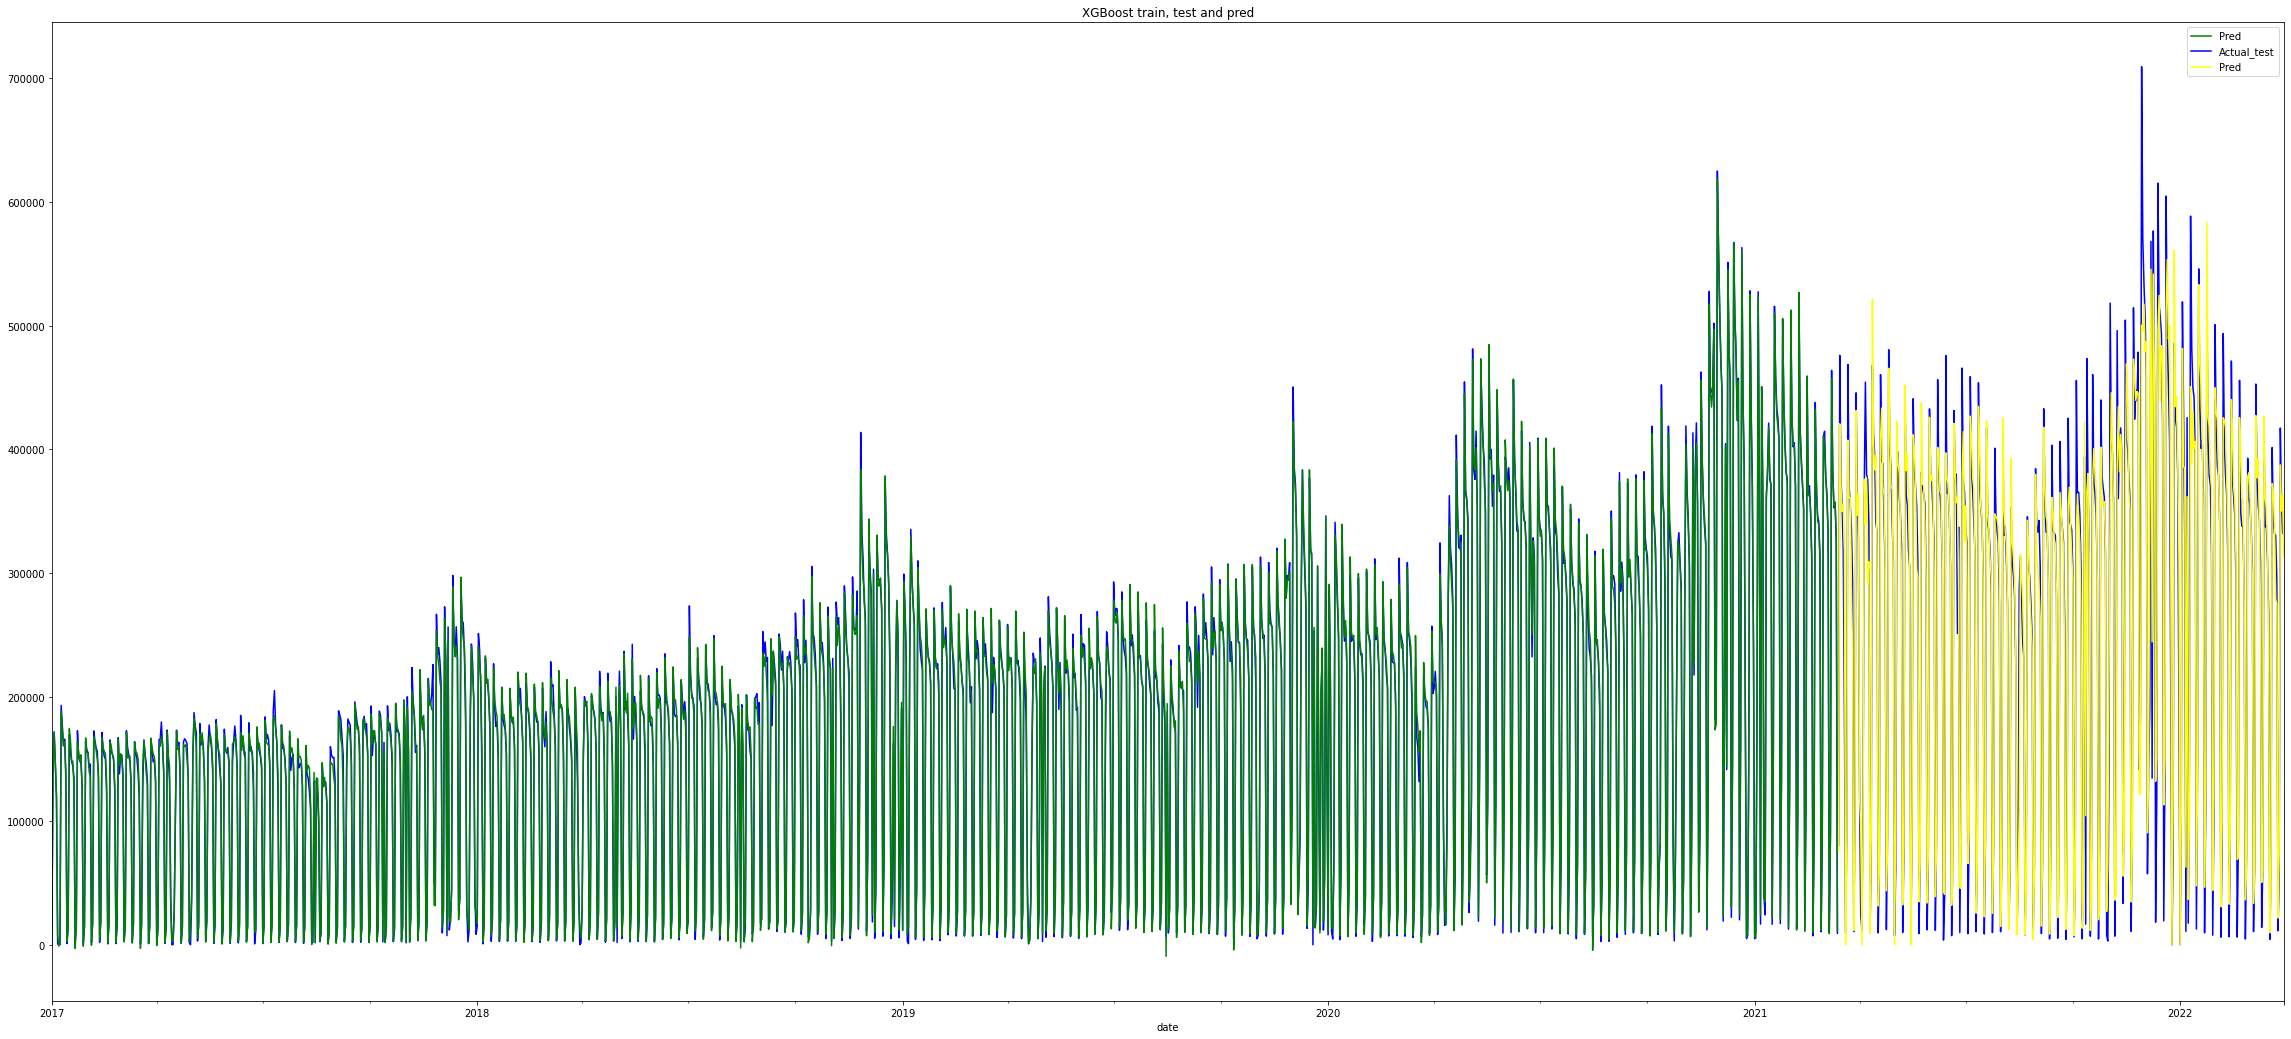

In [120]:
# Predict train
y_predictXGBtrain = estimatorXGB.predict(train_2017_X)
# Prepare and plot train and test data and predictions
act_train = pd.DataFrame(y.iloc[:train_size])
act_train.index = Xforindex.iloc[:train_size].index
predictions_XGB_train = pd.DataFrame()
predictions_XGB_train['Pred'] = y_predictXGBtrain
predictions_XGB_train.index = Xforindex.iloc[:train_size].index
predictions_XGB_train['Actual_train'] = act_train['n_parcels']
predictions_XGB_train['Actual_train'].plot(figsize=(40, 18), legend=False, color='blue')
predictions_XGB_train['Pred'].plot(figsize=(40, 18), legend=True, color='green')
predictions_XGB['Actual_test'].plot(figsize=(40, 18), legend=True, color='blue')
predictions_XGB['Pred'].plot(figsize=(40, 18), legend=True, color='yellow').set_title('XGBoost train, test and pred')

Now we need to train the model with all the data in order to use it later.

In [121]:
# Train model with all data
estimatorXGB_all = xgb.XGBRegressor(n_estimators=gscXGB.best_params_['n_estimators'])

estimatorXGB_all.fit(X, y)

[11:50:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=750)

Let's calculate the errors for the case with all the data, train and test.

Text(0.5, 1.0, 'XGBoost all data fit')

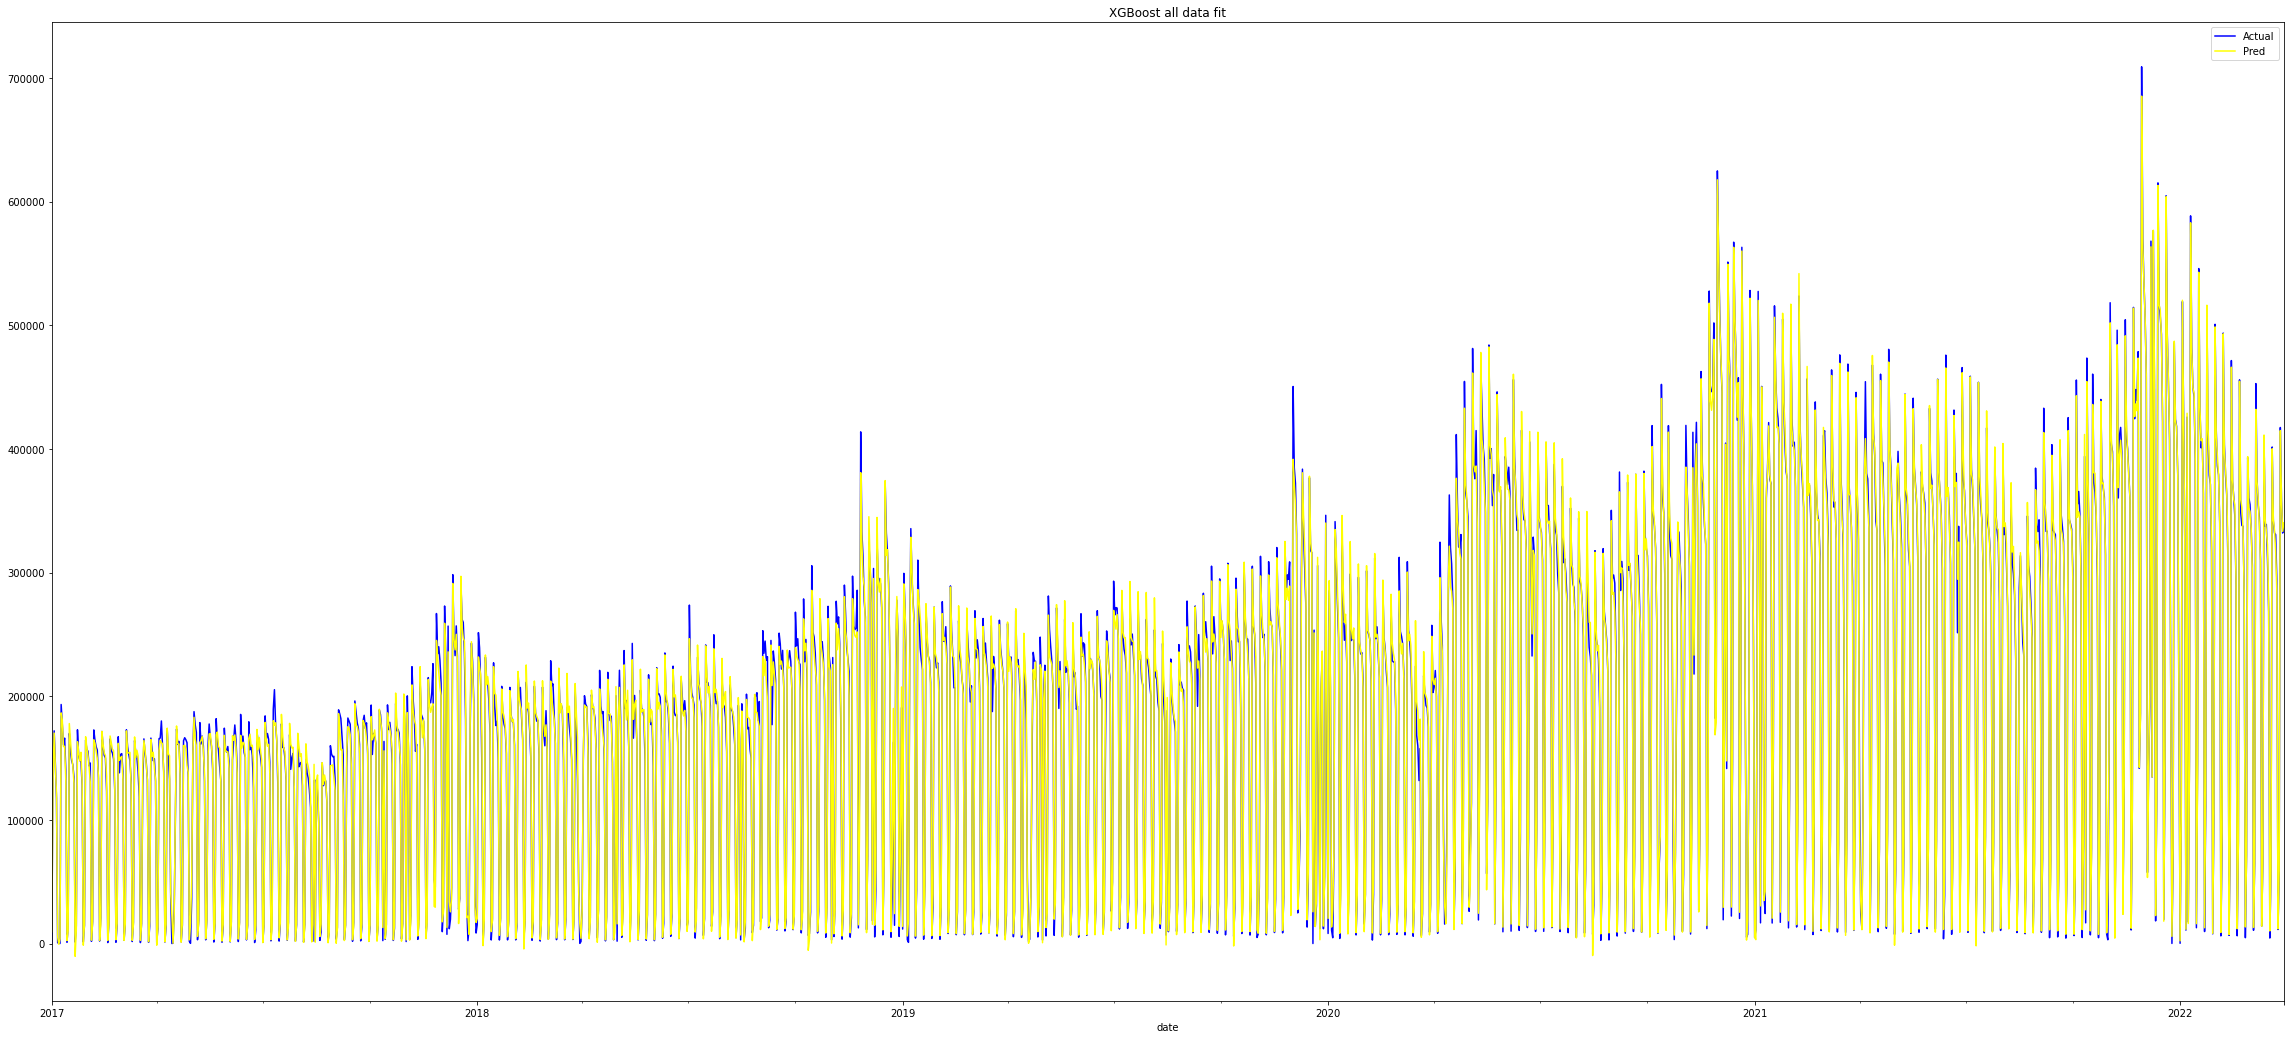

In [122]:
# Predict all data
y_predictXGBall = estimatorXGB_all.predict(X)
# Prepare and plot train and test data and predictions
predictions_XGB_all = pd.DataFrame()
predictions_XGB_all['Pred'] = y_predictXGBall
predictions_XGB_all['Actual'] = y
predictions_XGB_all.index = Xforindex.index
predictions_XGB_all['Actual'].plot(figsize=(40, 18), legend=True, color='blue')
predictions_XGB_all['Pred'].plot(figsize=(40, 18), legend=True, color='yellow').set_title('XGBoost all data fit')

In [123]:
# Print errors
print("RMSE")
print("Test: ", rmse(predictions_XGB['Pred'], predictions_XGB['Actual_test']))
print("Train: ", rmse(predictions_XGB_train['Pred'], predictions_XGB_train['Actual_train']))
print("All: ", rmse(predictions_XGB_all['Pred'], predictions_XGB_all['Actual']))
print("MAE")
print("Test: ", meanabs(predictions_XGB['Pred'], predictions_XGB['Actual_test']))
print("Train: ", meanabs(predictions_XGB_train['Pred'], predictions_XGB_train['Actual_train']))
print("All: ", meanabs(predictions_XGB_all['Pred'], predictions_XGB_all['Actual']))

RMSE
Test:  41747.45848379637
Train:  7397.914174484705
All:  10064.838343348687
MAE
Test:  28268.717798935217
Train:  5281.707952928637
All:  7100.831418572985


These results show that there is no overfitting beacuse the error in the case with all the data is greater than with only the train.

Finally, this model is saved so that we can use it later in the interface using joblib.

In [124]:
# save model
filename = '../files/save_model/XGB_model.sav'
joblib.dump(estimatorXGB_all, filename)

['../files/save_model/XGB_model.sav']